In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output
import time  

import calendar
import datetime
import urllib.request
import re
import sys
import pickle
import os.path
import scipy.misc

import os
import matplotlib

import pandas as pd


if not "DISPLAY" in os.environ:
    print("Setting to internal display")
    matplotlib.use("Agg")

print("My Name is:"+__name__)


class election():
    '''Class to create and display a state map based on colors.'''
    
    def __init__(self, csv_file, results = []):
        if results == []:
            results = election.poll(csv_file)
            
        #print(results)
        self.img =  scipy.misc.imread('state_labels2.png')
        #np.load('state_labels2.npy')
        self.img = self.img[:,:,0]
        self.states = election.stateList()
        self.votes = election.electorate()
        if results != []:
            self.majority_wins(results)
    
    def save_poll(filename=""):
        if filename =="":
            filename=str(datetime.date.today())+".p"
        polldata = election.poll()
        pickle.dump( polldata, open( filename, "wb" ) )
    
    def load_poll(filename=""):
        if filename =="":
            filename=str(datetime.date.today())+".p"
        if(os.path.isfile(fname)):
            polldata= pickle.load( open( filename, "rb" ) )
        return(polldata)
        
    def poll_ratings(fname='pollster-ratings.csv'):
        '''
        From: https://github.com/fivethirtyeight
        indices are as follows:
        0:ID, 1:Pollster, 2:Polls, 3:Live Caller With Cellphones, 4:Internet,
        5:NCPP/AAPOR/Roper, 6:Polls, 7:Simple Average Error, 8:Races Called Correctly,
        9:Advanced Plus-Minus, 10:Predictive Plus-Minus, 11:538 Grade, 
        12:Banned by 538, 13:Mean-Reverted Bias
        '''
        pollster_ratings = {}
        if os.path.isfile(fname):
            f = open(fname,'r')
            for line in f:
                index = 0
                for word in line.split(','):
                    if word=='ID':
                        break
                    if index==1:
                        poll = word
                    if index==7:
                        pollster_ratings[poll]=word
                        break
                    index+=1
        else:
            print("Pollster-rating file not found. Using defaults (10)")
        return pollster_ratings
    
    def delta_dates(d):
        a = d.split("/")
        year_start = a[2]
        t = datetime.date(year = int(a[2]), month = int(a[0]), day = int(a[1]))
        today = datetime.date.today()
        delta_date = today-t
        delta_int = abs(delta_date.days)
        return delta_int


    def weigh(recent_date = 1, voter = "rv", sample = 1000, grade = "C"):
        weight = 1

        date_weight = 1/(1+recent_date)

        if voter == "lv":
            voter_weight = 1
        elif voter == "rv":
            voter_weight = 0.5
        else:
            voter_weight = 0

        sample_weight = 1/(1+1/sample)


        grade_dict = {"A+": 1.0, "A": 0.98, "A-": 0.95, "B+": 0.92, "B": 0.88, "B-": 0.84, "C+": 0.79, "C": 0.72}
        if grade not in grade_dict:
            grade_weight = 0
        else:
            grade_weight = grade_dict[grade]

        weight = date_weight * voter_weight * sample_weight * grade_weight
        return weight


    def poll(file):
        ''''''
        df = pd.read_csv(file,na_values=" NaN")
        raw_polls_clinton = df['rawpoll_clinton']
        raw_polls_trump = df['rawpoll_trump']
        states = df['state']
        grades = df['grade'].tolist()
        voter_type = df['population'].tolist()
        startdate = df['startdate'].tolist()
        sample_size = df['samplesize'].tolist()
        rawpolls_clinton = raw_polls_clinton.tolist()
        rawpolls_trump = raw_polls_trump.tolist()
        startdate = df['startdate']

        all_states={}

        for i in range(len(df)):
            
            if rawpolls_trump[i] == "nan" or rawpolls_clinton[i] == "nan":
                continue
            else:
                if states[i] not in all_states and states[i] in election.getAbbrev():

                    abbrev = election.getAbbrev()[states[i]]
                    state = states[i]
                    all_states[abbrev] = [0,0]


                if states[i] in election.getAbbrev():
                    start_date = election.delta_dates(startdate[i])
                    weight = election.weigh(start_date, voter_type[i], sample_size[i], grades[i])

                    clinton_result = rawpolls_clinton[i]*weight
                    trump_result = rawpolls_trump[i]*weight
                    all_states[abbrev][0] += clinton_result
                    all_states[abbrev][1] += trump_result

        for s in all_states:
            total = all_states[s][0] + all_states[s][1]
            clinton_result = (all_states[s][0]/total)*100
            trump_result = (all_states[s][1]/total)*100
            print(clinton_result, trump_result)
            all_states[s] = (clinton_result, trump_result)
            
        #print(all_states)
            
        return all_states
    
    
    def getAbbrev():
        us_state_abbrev = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'District of Columbia': 'DC',
        'Delaware': 'DE',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY',
        }
        return us_state_abbrev
    
    def getnames():
        abbrev = election.getAbbrev()
        names = {}
        for key in abbrev:
            names[abbrev[key]] = key
        return names
    
    #Default eleciton results (used for testing) as randomly picked using out of date polling data.
    def polldefaults():
        defaults = {
            'WA':(1,0),
            'OR':(1,0),
            'CA':(1,0),
            'NV':(1,0),
            'AK':(0,1),
            'ID':(0,1),
            'UT':(0,1),
            'AZ':(0,1),
            'MT':(0,1),
            'WY':(0,1),
            'CO':(1,0),
            'NM':(1,0),
            'HI':(1,0),
            'ND':(0,1),
            'SD':(0,1),
            'NE':(0,1),
            'KS':(0,1),
            'OK':(0,1),
            'TX':(0,1),
            'MN':(1,0),
            'IA':(1,0),
            'MO':(0,1),
            'AR':(0,1),
            'LA':(0,1),
            'WI':(1,0),
            'IL':(1,0),
            'MS':(0,1),
            'IN':(0,1),
            'KY':(0,1),
            'TN':(0,1),
            'AL':(0,1),
            'MI':(1,0),
            'OH':(1,0),
            'GA':(0,1),
            'FL':(1,0),
            'SC':(0,1),
            'NC':(1,0),
            'VA':(1,0),
            'WV':(0,1),
            'MD':(1,0),
            'DE':(1,0),
            'NJ':(1,0),
            'RI':(1,0),
            'MA':(1,0),
            'ME':(1,0),
            'NH':(1,0),
            'VT':(1,0),
            'NY':(1,0),
            'PA':(1,0),
            'CT':(1,0)
        }
        return defaults
    
    def electorate():
        votes = {}
        #Sets of dictionaries to be used with dictionaryLabelStates()
        votes['AL'] = 9
        votes['AK'] = 3
        votes['AZ'] = 11
        votes['AR'] = 6
        votes['CA'] = 55
        votes['CO'] = 9
        votes['CT'] = 7
        votes['DC'] = 3
        votes['DE'] = 3
        votes['FL'] = 29
        votes['GA'] = 16
        votes['HI'] = 4 
        votes['ID'] = 4
        votes['IL'] = 20
        votes['IN'] = 11
        votes['IA'] = 6
        votes['KS'] = 6
        votes['KY'] = 8
        votes['LA'] = 8 
        votes['ME'] = 4
        votes['MD'] = 10 
        votes['MA'] = 11
        votes['MI'] = 16
        votes['MN'] = 10
        votes['MS'] = 6
        votes['MO'] = 10
        votes['MT'] = 3
        votes['NE'] = 5
        votes['NV'] = 6
        votes['NH'] = 4
        votes['NJ'] = 14
        votes['NM'] = 5
        votes['NY'] = 29 
        votes['NC'] = 15
        votes['ND'] = 3
        votes['OH'] = 18
        votes['OK'] = 7
        votes['OR'] = 7
        votes['PA'] = 20
        votes['RI'] = 4
        votes['SC'] = 9
        votes['SD'] = 3
        votes['TN'] = 11
        votes['TX'] = 38
        votes['UT'] = 6
        votes['VT'] = 3
        votes['VA'] = 13
        votes['WA'] = 12
        votes['WV'] = 5
        votes['WI'] = 10
        votes['WY'] = 3
        return votes    
    
    def stateList():
        states ={}
        states['AK']=0
        states['AL']=1
        states['AR']=2
        states['AZ']=3
        states['CA']=4
        states['CO']=5
        states['CT']=6
        states['DC']=7
        states['DE']=8
        states['FL']=9
        states['GA']=10
        states['HI']=11
        states['IA']=12
        states['ID']=13
        states['IL']=14
        states['IN']=15
        states['KS']=16
        states['KY']=17
        states['LA']=18
        states['MA']=19
        states['MD']=20
        states['ME']=21
        states['MI']=22
        states['MN']=23
        states['MO']=24
        states['MS']=25
        states['MT']=26
        states['NC']=27
        states['ND']=28
        states['NE']=29
        states['NH']=30
        states['NJ']=31
        states['NM']=32
        states['NV']=33
        states['NY']=34
        states['OH']=35
        states['OK']=36
        states['OR']=37
        states['PA']=38
        states['RI']=39
        states['SC']=40
        states['SD']=41
        states['TN']=42
        states['TX']=43
        states['UT']=44
        states['VA']=45
        states['VT']=46
        states['WA']=47
        states['WI']=48
        states['WV']=49
        states['WY']=50
        states['border']=255
        return states
   
    def majority_wins(self,results):
        #print(results)
        red_blue = np.zeros( (self.img.shape[0], self.img.shape[1], 3) )
        red_blue[self.img > 50,:] = [0.5,0.5,0.5]
        red_blue[self.img < 50,:] = [0.5,0.5,0.5]
        red_blue[self.img == self.states['border'],:] = [1,1,1]
        red = 0
        blue = 0
        for state in election.electorate():
            if state in results:
                #print(state)
                polldata = results[state]
                
                if polldata[0] > polldata[1]:
                    blue = blue + self.votes[state]
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0,0,1]
                elif polldata[1] > polldata[0]:
                    red = red + self.votes[state]
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [1,0,0]
                else:                       
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0.5,0.5,0.5]
            else:
                if state in self.states:
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0.5,0.5,0.5]
                        
        plt.figure(figsize = (10,20))
        plt.imshow(red_blue)
        plt.axis('off')
        if(red > 270):
            plt.title("Red Wins: "+str(red)+"/"+str(blue))
        elif(blue > 270):
            plt.title("Blue Wins: "+str(blue)+"/"+str(red))
        else:
            plt.title("No clear winner, Blue: "+str(blue)+" Red:"+str(red)+" --- 270 votes needed")
        return red_blue
    
    def disp_state_movie(self):
        fig, ax = plt.subplots(figsize=(10,5))
        for state in self.states:
            print(state)
            #for region in self.states[state]:
            plt.imshow(self.img == self.states[state])
            plt.title(state)

            # Animaiton part (dosn't change)
            clear_output(wait=True) # Clear output for dynamic display
            display(fig)            # Reset display
            fig.clear()             # Prevent overlapping and layered plots
            time.sleep(2)      # Sleep for a fraction of a second to allow animation to catch up
    

Setting to internal display
My Name is:__main__


/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [65]:
def delta_dates(d):
    a = d.split("/")
    year_start = a[2]
    t = datetime.date(year = int(a[2]), month = int(a[0]), day = int(a[1]))
    today = datetime.date.today()
    delta_date = today-t
    delta_int = abs(delta_date.days)
    return delta_int


def weigh(recent_date = 1, voter = "rv", sample = 1000, grade = "C"):
    weight = 1
    
    date_weight = 1/(1+recent_date)
    
    if voter == "lv":
        voter_weight = 1
    elif voter == "rv":
        voter_weight = 0.5
    else:
        voter_weight = 0
        
    sample_weight = 1/(1+1/sample)
        
        
    grade_dict = {"A+": 1.0, "A": 0.98, "A-": 0.95, "B+": 0.92, "B": 0.88, "B-": 0.84, "C+": 0.79, "C": 0.72}
    if grade not in grade_dict:
        grade_weight = 0
    else:
        grade_weight = grade_dict[grade]
        
    weight = date_weight * voter_weight * sample_weight * grade_weight
    return weight


def new_poll(file):
    ''''''
    df = pd.read_csv(file)
    raw_polls_clinton = df['rawpoll_clinton']
    raw_polls_trump = df['rawpoll_trump']
    #raw_polls_johnson = df['rawpoll_johnson']
    states = df['state']
    grades = df['grade'].tolist()
    voter_type = df['population'].tolist()
    startdate = df['startdate'].tolist()
    sample_size = df['samplesize'].tolist()
    #print(raw_polls_clinton)
    rawpolls_clinton = raw_polls_clinton.tolist()
    rawpolls_trump = raw_polls_trump.tolist()
    #rawpolls_johnson = raw_polls_johnson.tolist()
    startdate = df['startdate']

    all_states={}
    #print(states)
    
    for i in range(len(df)):
        if states[i] not in all_states and states[i] in election.getAbbrev():
            all_states[states[i]] = [0,0]
            
        #print(startdate[i], voter_type[i], sample_size[i], grades[i])

        if states[i] in election.getAbbrev():
            start_date = delta_dates(startdate[i])
            weight = weigh(start_date, voter_type[i], sample_size[i], grades[i])
            clinton_result = rawpolls_clinton[i]*weight
            trump_result = rawpolls_trump[i]*weight
            all_states[states[i]][0] += clinton_result
            all_states[states[i]][1] += trump_result
        #clinton_percent = clinton_result / (clinton_result + trump_result)
        
    for state in all_states:
        #print(all_states[state])
        total = all_states[state][0] + all_states[state][1]
        clinton_result = (all_states[state][0]/total)*100,
        trump_result = (all_states[state][1]/total)*100
        all_states[state] = (clinton_result, trump_result)
    #print("%.2f" % all_state)

date1 = delta_dates("11/1/2016")
weight1 = weigh(date1, "lv", 1000, "A+")
#print(weight1)

file = "./president_general_polls_2016.csv"
new_poll(file)

41.0040583196 58.9959416804
55.9523809524 44.0476190476
nan nan
52.0279942739 47.9720057261
47.2846955568 52.7153044432
57.0046534411 42.9953465589
35.0278884462 64.9721115538
46.9879518072 53.0120481928
50.5617977528 49.4382022472
24.8475393561 75.1524606439
28.2352941176 71.7647058824
54.5454545455 45.4545454545
49.1677201854 50.8322798146
nan nan
58.9861023373 41.0138976627
51.8987341772 48.1012658228
69.8897927053 30.1102072947
55.8441558442 44.1558441558
70.0682166226 29.9317833774
49.5125102784 50.4874897216
nan nan
53.0864197531 46.9135802469
37.445332529 62.554667471
41.5671803777 58.4328196223
55.8981073682 44.1018926318
42.5913908717 57.4086091283
86.3551132266 13.6448867734
nan nan
52.0 48.0
55.8333333333 44.1666666667
60.4584867561 39.5415132439
50.5617977528 49.4382022472
47.2162740899 52.7837259101
41.5838247683 58.4161752317
64.0557006092 35.9442993908
55.6818181818 44.3181818182
36.49883811 63.50116189
43.4254606365 56.5745393635
nan nan
nan nan
56.3882063882 43.6117936

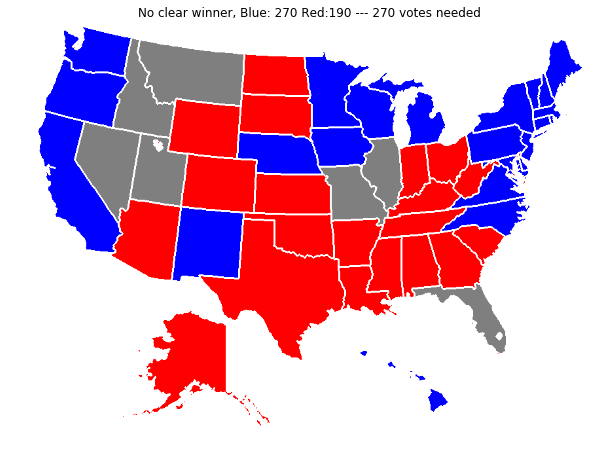

In [66]:
file = "./president_general_polls_2016.csv"
#file = "./test.csv"
e = election(file)